# 0.0 Text

## 1.0 Get Data and Greet Data
A dataset should be broken up into multiple datasets:

- data_raw = first read in of our data, but will not be touched
- data_copy = data_raw copied, which will be used to clean, feature engineer, and wrangle our data

In [1]:
import pandas as pd

data_raw = pd.read_csv('/Volumes/ExternalDrive/flickr30k_images/results.csv', delimiter='|')
data_copy = pd.read_csv('/Volumes/ExternalDrive/flickr30k_images/results.csv', delimiter='|')

In [2]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   image_name       158915 non-null  object
 1    comment_number  158915 non-null  object
 2    comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


We notice that we have a missing value in the comment section. This will be important to us as we clean our data later. The other two columns look like they do not have any missing data.

In [3]:
data_raw.sample(10)

,image_name,comment_number,comment
74924,3528715437.jpg,4,A Fancy outDoors Cafe on a Sunny Day .
124746,4908009544.jpg,1,A group of mature folk are waving as they wal...
53801,3049617203.jpg,1,"Man wearing a red , black , and white jacket ..."
3911,1262077938.jpg,1,A young woman with a black purse sits on a wo...
58260,3162399420.jpg,0,Two ladies wearing pajamas are laying in the ...
19401,2182575588.jpg,1,"A few people , mostly girls , sit around a ta..."
10752,1634820545.jpg,2,Three woman in skirts stand outside the PARC ...
144838,6678040861.jpg,3,An older lady in a dining area is adding food...
110376,4680389936.jpg,1,A man rides a jet ski across the ocean .
44091,2806447.jpg,1,Indian musicians playing in the evening on a ...


Our data is structured with three columns:

- image_name: which is the unique tag of the image
- comment_number: which is the specific comment number about the image
- comment: this is the actual comment left about the image <br>

We expect to see 5 comments per uniuqe image_id so let's make sure that is the case:

In [4]:
image_name_unique_vals = data_raw['image_name'].unique().tolist()
print("Total length of unique values: ", len(image_name_unique_vals))
print("Total length of data frame: ",  len(data_raw))
print("Total length of unique values * 5: ", len(image_name_unique_vals) * 5)

Total length of unique values:  31783
Total length of data frame:  158915
Total length of unique values * 5:  158915


## 1.1 The 4 C's of Data Cleaning: Correction, Completing, Creating, and Converting

In this stage, we will clean our data by:

1. correcting values and outliers
2. completing missing information
3. creating new features for analysis
4. converting fields to the correct format for calculations and presentation.

### 1.1.1 Correcting data

In [5]:
def preprocess_columns(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
preprocess_columns(data_copy)

In [6]:
print('Columns with null values:')
print(data_copy.isnull().sum())

Columns with null values:
image_name        0
comment_number    0
comment           1
dtype: int64


In [7]:
data_copy.describe(include = 'all').transpose()

,count,unique,top,freq
image_name,158915,31783,1000092795.jpg,5
comment_number,158915,6,0,31783
comment,158914,158438,Two dogs playing in the snow .,7


Let's take a look at the comment_number issue because we should have 5 unique comment_numbers not 6:

In [8]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print(comment_number_unique_vals)

[' 0', ' 1', ' 2', ' 3', ' 4', ' 4   A dog runs across the grass .']


In [9]:
data_copy[data_copy['comment'].isnull()]

,image_name,comment_number,comment
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


In [10]:
#Filter location to where the data is missing a value
data_copy[data_copy['image_name'] == '2199200615.jpg']
#Create a temporary variable to hold that row
tmp = data_copy.iloc[19999]

#Get the comment number column
holder = tmp['comment_number']

#Seperate the text from the digit and print
result = ''.join([i for i in holder if not i.isdigit()])

#Update the temporary variable row
tmp['comment'] = result 
tmp['comment_number'] = '4'

#Update our data copy row to reflect change
data_copy.iloc[19999] = tmp
print(data_copy.iloc[19999])

image_name                           2199200615.jpg
comment_number                                    4
comment               A dog runs across the grass .
Name: 19999, dtype: object


In [11]:
print('Updated Columns with null values:') 
print(data_copy.isnull().sum())

Updated Columns with null values:
image_name        0
comment_number    0
comment           0
dtype: int64


In [12]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print(comment_number_unique_vals)

[' 0', ' 1', ' 2', ' 3', ' 4', '4']


In [13]:
data_copy['comment_number'] = data_copy['comment_number'].str.lstrip()

In [14]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print(comment_number_unique_vals)

['0', '1', '2', '3', '4']


#### Make a new column that will hold our cleaned data for each comment:

In [15]:
data_copy['cleaned_comment'] = data_copy['comment']

In [16]:
import contractions

def expand_contractions(comment):
    """
    This function will expand all contractions to get rid of them.

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
       Object: A fixed object that has all the punctuations taken out of the sentence
    """
    comment = contractions.fix(comment)
    return comment

data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(expand_contractions)

In [17]:
import string

def remove_punctuations(comment):
    """
    This function will go through all the comment rows and remove all punctuations.
    
    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    for letter in string.punctuation:
        comment = comment.replace(letter, '')
    return comment

data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(remove_punctuations) #call function on dataframe to remove punctuations

In [18]:
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].str.lower() #convert all letters in the comment column to lowercase

In [19]:
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].str.strip() #get rid of all whitespace in the comment column

In [20]:
from collections import Counter

Counter(" ".join(data_copy["cleaned_comment"]).split()).most_common(100)

[('a', 271705),
 ('in', 83466),
 ('the', 62982),
 ('on', 45669),
 ('and', 44263),
 ('man', 42598),
 ('is', 41146),
 ('of', 38779),
 ('with', 36207),
 ('woman', 22211),
 ('two', 21642),
 ('are', 20211),
 ('to', 17609),
 ('people', 17337),
 ('at', 16259),
 ('an', 15883),
 ('wearing', 15709),
 ('young', 13218),
 ('white', 13178),
 ('shirt', 12981),
 ('black', 12311),
 ('while', 11711),
 ('his', 11495),
 ('blue', 11310),
 ('red', 9916),
 ('girl', 9655),
 ('sitting', 9620),
 ('men', 9498),
 ('boy', 9429),
 ('standing', 9113),
 ('dog', 9090),
 ('playing', 8620),
 ('street', 7998),
 ('group', 7852),
 ('down', 7678),
 ('front', 7604),
 ('her', 7414),
 ('walking', 7339),
 ('holding', 6985),
 ('one', 6484),
 ('water', 5957),
 ('by', 5771),
 ('three', 5770),
 ('women', 5275),
 ('green', 5221),
 ('up', 5114),
 ('child', 5078),
 ('looking', 5067),
 ('as', 5028),
 ('for', 4899),
 ('little', 4794),
 ('large', 4753),
 ('outside', 4702),
 ('yellow', 4557),
 ('person', 4479),
 ('children', 4454),
 ('bro

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize

stop = stopwords.words('english') #assign all stopwords to variable stop
data_copy['cleaned_comment'] = data_copy['cleaned_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #remove stopwor

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blakedickerson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/blakedickerson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
Counter(" ".join(data_copy["cleaned_comment"]).split()).most_common(100)

[('man', 42598),
 ('woman', 22211),
 ('two', 21642),
 ('people', 17337),
 ('wearing', 15709),
 ('young', 13218),
 ('white', 13178),
 ('shirt', 12981),
 ('black', 12311),
 ('blue', 11310),
 ('red', 9916),
 ('girl', 9655),
 ('sitting', 9620),
 ('men', 9498),
 ('boy', 9429),
 ('standing', 9113),
 ('dog', 9090),
 ('playing', 8620),
 ('street', 7998),
 ('group', 7852),
 ('front', 7604),
 ('walking', 7339),
 ('holding', 6985),
 ('one', 6484),
 ('water', 5957),
 ('three', 5770),
 ('women', 5275),
 ('green', 5221),
 ('child', 5078),
 ('looking', 5067),
 ('little', 4794),
 ('large', 4753),
 ('outside', 4702),
 ('yellow', 4557),
 ('person', 4479),
 ('children', 4454),
 ('brown', 4446),
 ('hat', 4037),
 ('ball', 3892),
 ('small', 3779),
 ('next', 3752),
 ('dressed', 3462),
 ('another', 3372),
 ('running', 3369),
 ('building', 3360),
 ('jacket', 3348),
 ('riding', 3313),
 ('around', 3134),
 ('orange', 3086),
 ('near', 3016),
 ('field', 2981),
 ('crowd', 2963),
 ('stands', 2935),
 ('beach', 2904),


## 1.1.2 Creating

In [23]:
import numpy as np

def classify_images(dataframe):
    '''
    A function to turn the images to a label classifying them

    Args: 
        df: a dataframe
    
     '''
    dic = dict()                             #dictionary to hold our unique labels
    label_list = list()                      #list to hold all of the labels
    data_copy['label'] = np.nan              #create a new column which will be our label column
    temp_counter = 0                         #temporary counting variable
    for value in dataframe['image_name']:
        if value not in dic:
            dic[value] = temp_counter        #assign the counter as the value while the image_name is the key
            temp_counter+=1
    images = dataframe['image_name'].tolist()#put the image_name column values in a list
    for image in images:
        label_list.append(dic[image])
    dataframe['label'] = label_list          #update label column to the correct value

classify_images(data_copy)
data_copy.head()

,image_name,comment_number,comment,cleaned_comment,label
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys shaggy hair look hands hanging ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many...",two young white males outside near many bushes,0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men green shirts standing yard,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,man blue shirt standing garden,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together,0


## 1.3 Feature Engineering

I want to find the average length of each comment in order to see how many tags we should take out:

In [24]:
def count_words(comment):
    """
    This function will count the amount of words in each comment

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    return len(comment.split()) #split the string on each space

In [25]:
def count_unique_words(comment):
    """
    This function will count the amount of unique words in a comment

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    return len(set(comment.split()))

In [26]:
def count_unique_words_vs_word_count(num_words, num_unique):
    """
    This function will count the number of unique words vs the total words per sentence

    Args:
        num_words (int): number of words per sentence
        num_unique (int): number of unique words per sentence

    Returns:
        Float: the ratio of unique words to total words
    """
    return num_unique/num_words

In [27]:
data_copy['word_count'] = data_copy['comment'].apply(lambda x : count_words(x))
data_copy['unique_word_count'] = data_copy['comment'].apply(lambda x : count_unique_words(x))
data_copy['unique_words_vs_words'] = data_copy['unique_word_count']/data_copy['word_count']

In [28]:
data_copy.head()

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys shaggy hair look hands hanging ...,0,17,17,1.000000
1,1000092795.jpg,1,"Two young , White males are outside near many...",two young white males outside near many bushes,0,11,11,1.000000
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men green shirts standing yard,0,11,10,0.909091
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,man blue shirt standing garden,0,11,9,0.818182
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together,0,7,7,1.000000


## Prepping Our Model
- Our model will consist of three parts:
    1. Noisy tags, which we will extract from each sentence
        - We will grab keywords using [yake](https://github.com/LIAAD/yake/blob/master/README.md)
            - We will use the keywords extracted from yake and create a new column holding those words and their weights
            
        - We will compute the nouns and verbs ('noisy tags') over the whole df and add these to a new column using [NLTK](https://www.nltk.org/)
            - We will use these nouns and verbs extracted to create a new column holding them
            
            <br>
    2. The sentence itself
        - Tokenize our data using [AutoProcessor](https://huggingface.co/docs/transformers/main_classes/processors)
            - `AutoProcessor` always works and automatically chooses the correct class for the model you are using
                - The `AutoProcessor` will use a pretrained bert model 
       
       - Generate tokens for each word:
           - BERT expects inputIds and attention masks
               - `inputIds`: a mapping between tokens and their ids
                   - each word in the vector has a unique id, the input id maps this unique id to its token
               - `attention mask`: depicts where the padding are in the comment
                   - 1 indicates that the mask should perform an action
                   - 0 indicates that it is a padding value and should be left alone
                   
       - Generate training data
           - [encode_plus](https://huggingface.co/docs/transformers/v4.26.1/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus) will turn our comments into a matrix of integers
           - We will turn our original dataset into a tf.data.Dataset and split 80/20 using .skip and .take
           
            
            
            
            
    3. The image<br><br>
- We need to use a tokenizer:
    1. convert text into a sequence of tokens
    2. create a numerical representation of the tokens
    3. assemble them into tensors 
    <br><br>
   


Since the data is massive, I will split the data into the first 100 rows to get a feel on how the data will perform.

In [29]:
import yake


data_copy = data_copy[:100]

def extract_noisy_tags(df, 
                       column_name, 
                       language='en', 
                       max_ngram_size=3, 
                       dedupLim=0.9, 
                       dedupFunc='seqm', 
                       num_keywords=5):
    '''
        This function will use the yake library to grab the highest weighted tags from each comment
        
        args:
            df: pandas dataframe
            column_name: the name of the column needed to extract information from
            language: english
            max_ngram_size: maximum number of n-grams to consider
            dedupLim: threshold cutoff
            dedupFunc: algorithm specification
            num_keywords: number of keywords to extract
            
        return:
            pandas dataframe
    '''
    
    kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, top=num_keywords) #create the keyword extractor object with paramerts
    keyword_counts = []
    for sentence in df[column_name]:
        keywords = kw_extractor.extract_keywords(sentence) #extract the keywords from the sentence
        keyword_counts.append(keywords)                    #add the keywords to the list
    df['keywords'] = keyword_counts                        #create a new column and add the 'noisy tags'
    return df

data_copy = extract_noisy_tags(data_copy, 'comment')


In [30]:
nltk.download('averaged_perceptron_tagger')

def extract_nouns_verbs(df, column_name):
    '''
        This function will use the NLTK library to tag the nouns and verbs from each commment and put them in a new column
        
        args:
            df: pandas dataframe
            column_name: the name of the column needed to extract information from

        return:
            pandas dataframe
    '''
        
    nouns_verbs = []
    for sentence in df[column_name]:
        tokens = nltk.word_tokenize(sentence) #tokenize each word in the sentence
        tagged = nltk.pos_tag(tokens)         #part of speech tagging
        nv = [word for (word, pos) in tagged if pos.startswith('N') or pos.startswith('V')] #get the nouns and verbs from the tagged data
        nouns_verbs.append(nv) #add nouns and verbs to list
    df['noisy_tags'] = nouns_verbs
    return df

data_copy = extract_nouns_verbs(data_copy, 'comment')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/blakedickerson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [31]:
data_copy.head()

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words,keywords,noisy_tags
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys shaggy hair look hands hanging ...,0,17,17,1.000000,"[(young guys, 0.09700399286574239), (guys with...","[guys, hair, look, hands, hanging, yard]"
1,1000092795.jpg,1,"Two young , White males are outside near many...",two young white males outside near many bushes,0,11,11,1.000000,"[(White males, 0.026233073037508336), (White, ...","[White, males, are, bushes]"
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men green shirts standing yard,0,11,10,0.909091,"[(men in green, 0.02570861714399338), (green s...","[men, shirts, are, standing, yard]"
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,man blue shirt standing garden,0,11,9,0.818182,"[(blue shirt standing, 0.0016012214736657916),...","[man, shirt, standing, garden]"
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together,0,7,7,1.000000,"[(friends enjoy time, 0.03339840940482845), (e...","[friends, time, spent]"


In [32]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [33]:
sequence_len = 512
number_of_samples = len(data_copy)
num_classes = int(number_of_samples / 5)

Xids = np.zeros((number_of_samples, sequence_len))       #create a zero array with sequence len columns and num samples rows
attn_masks = np.zeros((number_of_samples, sequence_len)) #create a zero array with sequence len columns and num samples rows


In [34]:
Xids.shape, attn_masks.shape

((100, 512), (100, 512))

In [35]:
from tqdm.auto import tqdm

def generate_training_data(df, ids, masks, tokenizer):
    '''
        This function will encode each comment 1 by 1
        
        args:
            df: pandas dataframe
            ids: Xids
            masks: attn_mask
            tokenizer: huggingface AutoTokenizer
            
        return:
            ids, masks
    '''
    for i, text in tqdm(enumerate(df['comment'])):
        tokenized_text = tokenizer.encode_plus(
                              text,
                              max_length=sequence_len,      #max length of each comment so we can truncate if needed
                              truncation=True,              #if the comment is longer than max_length only take up to max_length values
                              padding='max_length',         #make all elements the same size of max_length
                              add_special_tokens=True,      #add [cls] [pad] [sep]
                              return_tensors='tf'           #return the data as tensorflow tensors
        )
        ids[i, :] = tokenized_text.input_ids          #at current index to the end tokenize the input ids
        masks[i, :] = tokenized_text.attention_mask   #at current index to the end tokenize the mask
    return ids, masks

In [36]:
Xids, attn_masks = generate_training_data(data_copy, Xids, attn_masks, tokenizer)

0it [00:00, ?it/s]

Metal device set to: Apple M1 Pro


2023-02-16 16:25:55.035107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-16 16:25:55.035298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [37]:
Xids

array([[ 101., 1960., 1685., ...,    0.,    0.,    0.],
       [ 101., 1960., 1685., ...,    0.,    0.,    0.],
       [ 101., 1960., 1441., ...,    0.,    0.,    0.],
       ...,
       [ 101., 3396., 1535., ...,    0.,    0.,    0.],
       [ 101.,  138., 9670., ...,    0.,    0.,    0.],
       [ 101.,  138., 1372., ...,    0.,    0.,    0.]])

In [38]:
attn_masks

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [39]:
labels = np.zeros((number_of_samples, num_classes))
labels.shape

(100, 20)

In [40]:
labels[np.arange(number_of_samples), data_copy['label'].values] = 1

In [41]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [42]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, attn_masks, labels)) #turn our data into tensors
dataset.take(1) #take a random sample of the data

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(20,), dtype=tf.float64, name=None))>

In [43]:
def SentimentDatasetMapFunction(input_ids, attention_masks, labels):
    '''
        This function will convert our dataset to its required format by mapping our values
        
        args:
            input_ids: Xids
            attention_masks: attn_masks
            labels: labels
            
        return:
            inputs_ids, attention_masks, labels
    '''
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels

dataset = dataset.map(SentimentDatasetMapFunction)

In [44]:
dataset.take(1) #take a random sample of the data

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(20,), dtype=tf.float64, name=None))>

In [45]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True) #create a random seed for distribution

In [46]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 20), dtype=tf.float64, name=None))>

In [47]:
p = 0.8
train_size = int((number_of_samples // batch_size) * p) #for each batch we will have # of samples / batch_size and take out 80% of that to train with

In [48]:
train_size

4

In [49]:
train_dataset = dataset.take(train_size) #create train dataset
val_dataset = dataset.skip(train_size)   #create test dataset

## Building our Model

In [50]:
from transformers import TFBertModel

model = TFBertModel.from_pretrained('bert-base-cased') #instantiate model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [51]:
#we need to input layers, input_ids and attention_masks
input_ids = tf.keras.layers.Input(shape=(sequence_len,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

#embedding layer, serves as an pooled layer[1], can also change to an activation layer[0]
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#hidden layer, creates a Dense layer with sequence_len * 2 neurons can change neurons and activations
hidden_layer = tf.keras.layers.Dense(sequence_len*2, activation='relu', name='hidden_layer')(bert_embds)

#can create other hidden layers here too if needed

#output layer, takes in the number of classes for neurons, using softmax because is calculates probability of classes
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(hidden_layer) 

#build model
built_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
built_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [52]:
#create optimizer, can change learning rate if needed 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=0.000001)
#create loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()
#create accuracy metrics
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [53]:
built_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy]) #compile model

In [54]:
#create model history
built_model_history = built_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50


2023-02-16 16:26:53.480060: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-16 16:26:53.484092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 3.1045 - accuracy: 0.0625

2023-02-16 16:27:28.269621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 40s 9s/step - loss: 3.1045 - accuracy: 0.0625 - val_loss: 3.0756 - val_accuracy: 0.0312
Epoch 2/50
4/4 [==============================] - 38s 10s/step - loss: 3.0400 - accuracy: 0.1094 - val_loss: 3.2333 - val_accuracy: 0.0312
Epoch 3/50
4/4 [==============================] - 34s 8s/step - loss: 3.0336 - accuracy: 0.0938 - val_loss: 2.9961 - val_accuracy: 0.0625
Epoch 4/50
4/4 [==============================] - 36s 9s/step - loss: 2.9918 - accuracy: 0.0938 - val_loss: 2.9735 - val_accuracy: 0.0312
Epoch 5/50
4/4 [==============================] - 33s 9s/step - loss: 2.9291 - accuracy: 0.1094 - val_loss: 2.8571 - val_accuracy: 0.1562
Epoch 6/50
4/4 [==============================] - 37s 10s/step - loss: 2.8946 - accuracy: 0.1094 - val_loss: 2.8232 - val_accuracy: 0.0625
Epoch 7/50
4/4 [==============================] - 41s 10s/step - loss: 2.8331 - accuracy: 0.1406 - val_loss: 2.7874 - val_accuracy: 0.1562
Epoch 8/50
4/4 [==========================

## Evaluating our Model

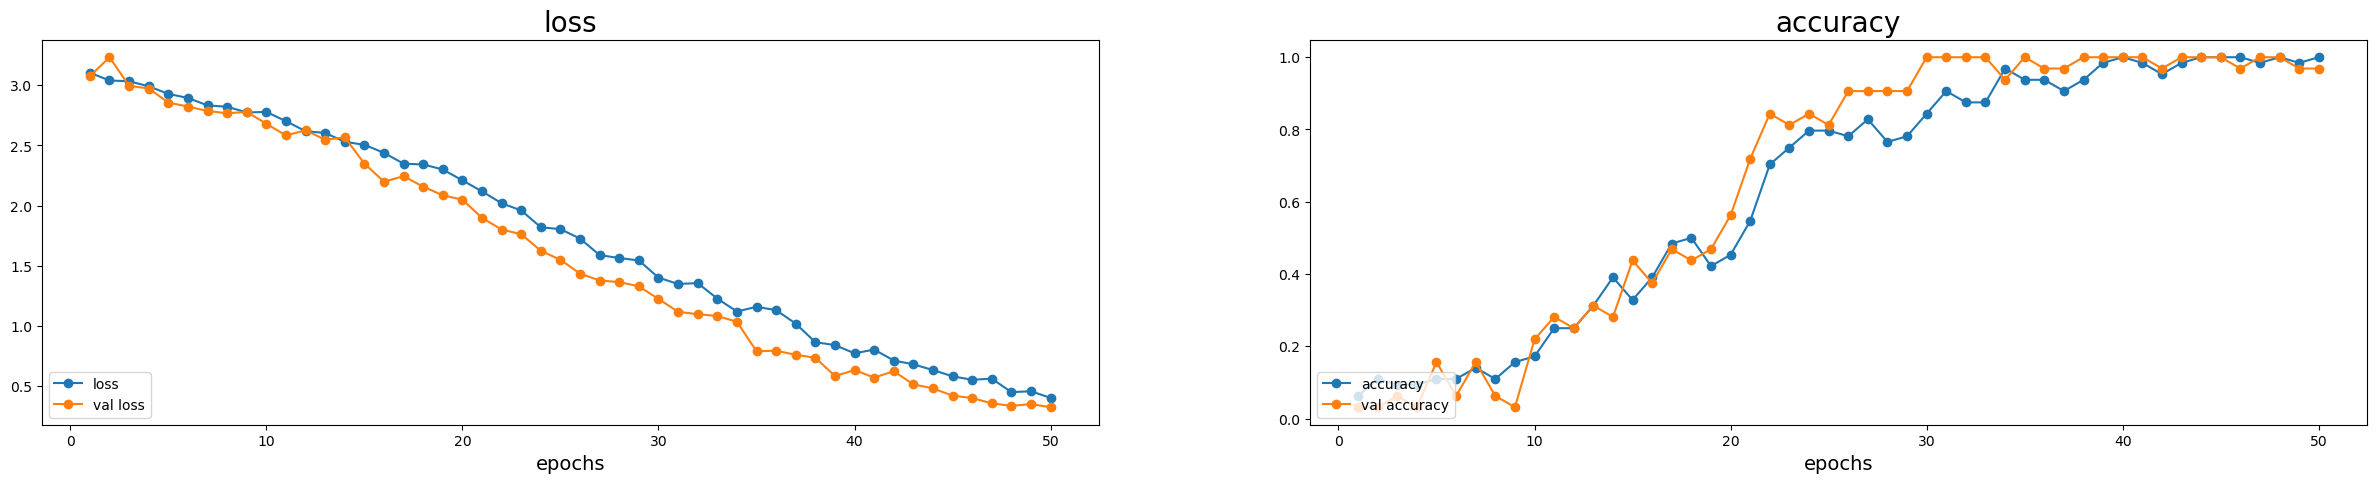

In [59]:
import matplotlib.pyplot as plt

x = list(range(1, 50+1))
metric_list = list(built_model_history.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, built_model_history.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, built_model_history.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

## Predictions

In [60]:
class_list = []
for i in range(0,num_classes):
    class_list.append(i)

print(class_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [61]:
def prepare_data(text, tokenizer):
    token = tokenizer.encode_plus(
        text,
        max_length=sequence_len, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }


In [62]:
def make_prediction(model, processed_data, classes=class_list):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [67]:
data_copy.sample(1)

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words,keywords,noisy_tags
51,1001573224.jpg,1,Ballet dancers in a studio practice jumping w...,ballet dancers studio practice jumping wonderf...,10,11,11,1.0,"[(studio practice jumping, 0.03339840940482845...","[Ballet, dancers, studio, practice, jumping, f..."


In [70]:
input_text = 'Ballet dancers in a studio'
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(built_model, processed_data=processed_data)
print(f"Predicted Label: {result}")

1/1 [==============================] - 0s 358ms/step
Predicted Label: 10


In [69]:
data_copy[data_copy['label']==10]

,image_name,comment_number,comment,cleaned_comment,label,word_count,unique_word_count,unique_words_vs_words,keywords,noisy_tags
50,1001573224.jpg,0,Five ballet dancers caught mid jump in a danc...,five ballet dancers caught mid jump dancing st...,10,17,16,0.941176,"[(ballet dancers caught, 0.0042542192213185686...","[ballet, dancers, caught, jump, dancing, studi..."
51,1001573224.jpg,1,Ballet dancers in a studio practice jumping w...,ballet dancers studio practice jumping wonderf...,10,11,11,1.000000,"[(studio practice jumping, 0.03339840940482845...","[Ballet, dancers, studio, practice, jumping, f..."
52,1001573224.jpg,2,Five girls are leaping simultaneously in a da...,five girls leaping simultaneously dance practi...,10,11,11,1.000000,"[(dance practice room, 0.016559150827736194), ...","[girls, are, leaping, dance, practice, room]"
53,1001573224.jpg,3,Five girls dancing and bending feet in ballet...,five girls dancing bending feet ballet class,10,10,10,1.000000,"[(ballet class, 0.04940384002065631), (girls d...","[girls, dancing, bending, feet, ballet, class]"
54,1001573224.jpg,4,A ballet class of five girls jumping in seque...,ballet class five girls jumping sequence,10,10,10,1.000000,"[(jumping in sequence, 0.04940384002065631), (...","[ballet, class, girls, jumping, sequence]"
